# Rotated Well Stochastic Integrator

In this notebook we write an EM scheme for simulating the noisy 2D double rotated double well

In [1]:
# Standard Package imports
import numpy as np
import numpy.linalg as la
import numpy.random as rm
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# from fancyWell import *

## Integration Setup

In [2]:
def grad_V(x):
    return np.array([x[0]*(x[0]**2 -1), 2 * x[1]])

In [3]:
# Problem Setup

R = np.array([[0, -1], [1, 0]]) # 90 degree rotation matrix

alpha = 10.
eps = 0.1
p = [alpha, eps]
dt = 0.01
tf = 10
time = np.arange(0, tf, dt)

In [4]:
def drift(x, p):
    alpha, eps = p
    return - (np.eye(2) + alpha * R) @ grad_V(x)

def euler_maruyama(x0, t, p, timer=False):
    alpha, eps = p
    N = len(t)
    x = np.zeros(np.append(N, x0.shape))
    x[0] = x0
    for i in tqdm(range(N-1), disable=not timer):
        dt = t[i+1]-t[i]
        dWt = rm.normal(0, np.sqrt(dt), 2)
        x[i+1] = x[i] + drift(x[i], p) * dt + np.sqrt(eps) * dWt
    return x

In [5]:
cold_point = np.array([-1, 0])
hot_point = np.array([1, 0])
saddle = np.array([0, 0])

## Running Ensemble of Stochastic Integrations

In [6]:
# Integration 

cold_ensemble = []
hot_ensemble = []
ensemble_size = int(1.e3)

for i in tqdm(range(ensemble_size)):
    cold_ensemble.append(euler_maruyama(cold_point, time, p))
    
for i in tqdm(range(ensemble_size)):
    hot_ensemble.append(euler_maruyama(hot_point, time, p))

/rds/general/user/cfn18/home/anaconda3/envs/personalpy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/rds/general/user/cfn18/home/anaconda3/envs/personalpy3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in matmul
  This is separate from the ipykernel package so we can avoid doing imports until
/rds/general/user/cfn18/home/anaconda3/envs/personalpy3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]


In [7]:
# Putting Results in xarray dataset and Saving

dims = ['x', 'y']
coords = [time]
attrs = {'alpha': alpha, 'eps': eps}

# Cold Ensemble
data = np.asarray(cold_ensemble)
x_data = xr.DataArray(data[:, :, 0], coords = {'realisation':np.arange(len(cold_ensemble)) + 1,
                                    'time': time},
                    dims = ['realisation','time'], attrs=attrs, name='x')
y_data = xr.DataArray(data[:, :, 1], coords = {'realisation':np.arange(len(cold_ensemble)) + 1,
                                    'time': time},
                    dims = ['realisation','time'], attrs=attrs, name='y')
cold_ensemble_ds = xr.merge([x_data, y_data])
cold_ensemble_ds.attrs = attrs

# Hot Ensemble

data = np.asarray(hot_ensemble)
x_data = xr.DataArray(data[:, :, 0], coords = {'realisation':np.arange(len(hot_ensemble)) + 1,
                                    'time': time},
                    dims = ['realisation','time'], attrs=attrs, name='x')
y_data = xr.DataArray(data[:, :, 1], coords = {'realisation':np.arange(len(hot_ensemble)) + 1,
                                    'time': time},
                    dims = ['realisation','time'], attrs=attrs, name='y')
hot_ensemble_ds = xr.merge([x_data, y_data])
hot_ensemble_ds.attrs = attrs

In [8]:
cold_ensemble_ds.to_netcdf(f'Data/alpha{alpha}-cold-ensemble'.replace('.', '_') + '.nc')
hot_ensemble_ds.to_netcdf(f'Data/alpha{alpha}-hot-ensemble'.replace('.', '_') + '.nc')

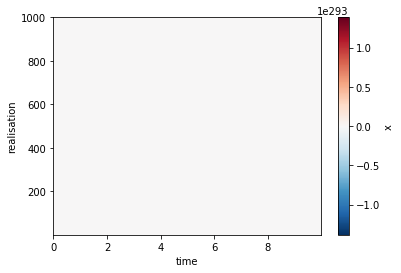

In [11]:
cold_ensemble_ds.x.plot()